# <center> Идентификация интернет-пользователей

## Цели и задачи проекта:
Идентификация пользователя $-$ это задача, которая стоит на стыке анализа данных и поведенческой психологии. Она актуальна на сегодняшний день, например, для идентификации возломщика почтового ящика по его поведению в сети.

Задачей данного проекта является идентифицировать пользователя по последовательности посещенных веб-сайтов.

Данные взяты [статьи](http://ceur-ws.org/Vol-1703/paper12.pdf) "A Tool for Classification of Sequential Data", которые были взяты с прокси-серверов Университета Блеза Паскаля и имеют следующую структуру. Для каждого пользователя заведен csv-файл с названием user\*\*\*\*.csv (где вместо звездочек – 4 цифры, соответствующие ID пользователя), а в нем посещения сайтов записаны в следующем формате: *timestamp*, *посещенный веб-сайт*

В нашем распоряжении будет 2 выборки: по 10 пользователям и по 150. Для 10 пользователей будем писать и отлаживать код, для 150 – будет рабочая версия.

## Подготовка данных к анализу

In [206]:
import warnings
warnings.filterwarnings('ignore')

from glob import glob
import os
import pickle
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import probplot, shapiro
from statsmodels.stats.proportion import proportion_confint
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from itertools import product
from scipy.sparse import hstack

In [2]:
PATH_TO_DATA = 'capstone_user_identification'

Посмотрим на один из файлов с данными о посещенных пользователем (номер 31) веб-страницах.

In [3]:
user31_data = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                       '10users/user0031.csv'))
user31_data.head()

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net


В конечном итоге перед нами поставлена следующая задача: идентифицировать пользователя по сессии из $n$ подряд посещенных сайтов. Объектом в этой задаче будет сессия из $n$ сайтов, последовательно посещенных одним и тем же пользователем, признаками – индексы этих $n$ сайтов.

Чтобы наши данные имели структуру пригодную для анализа и построения модели, мы, во-первых, сопоставим каждый уникальный сайт со своим уникальным идентификатором, а также для каждого пользователя построим последовательности из $n$ пордряд идущих сайтов.

Например, для 2 пользователей и $n=2$  наши преобразования будут выглядеть следующим образом.

<center>user0001.csv</center>
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">timestamp</th>
    <th class="tg-031e">site</th>
  </tr>
  <tr>
    <td class="tg-031e">00:00:01</td>
    <td class="tg-031e">vk.com</td>
  </tr>
  <tr>
    <td class="tg-yw4l">00:00:11</td>
    <td class="tg-yw4l">google.com</td>
  </tr>
  <tr>
    <td class="tg-031e">00:00:16</td>
    <td class="tg-031e">vk.com</td>
  </tr>
  <tr>
    <td class="tg-031e">00:00:20</td>
    <td class="tg-031e">yandex.ru</td>
  </tr>
</table>

<center>user0002.csv</center>
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">timestamp</th>
    <th class="tg-031e">site</th>
  </tr>
  <tr>
    <td class="tg-031e">00:00:02</td>
    <td class="tg-031e">yandex.ru</td>
  </tr>
  <tr>
    <td class="tg-yw4l">00:00:14</td>
    <td class="tg-yw4l">google.com</td>
  </tr>
  <tr>
    <td class="tg-031e">00:00:17</td>
    <td class="tg-031e">facebook.com</td>
  </tr>
  <tr>
    <td class="tg-031e">00:00:25</td>
    <td class="tg-031e">yandex.ru</td>
  </tr>
</table>

Отображение сайтов в их индесы должно получиться таким:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">site</th>
    <th class="tg-yw4l">site_id</th>
  </tr>
  <tr>
    <td class="tg-yw4l">vk.com</td>
    <td class="tg-yw4l">1</td>
  </tr>
  <tr>
    <td class="tg-yw4l">google.com</td>
    <td class="tg-yw4l">2</td>
  </tr>
  <tr>
    <td class="tg-yw4l">yandex.ru</td>
    <td class="tg-yw4l">3</td>
  </tr>
  <tr>
    <td class="tg-yw4l">facebook.com</td>
    <td class="tg-yw4l">4</td>
  </tr>
</table>

Тогда обучающая выборка будет такой (целевой признак – user_id):
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-s6z2{text-align:center}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-hgcj{font-weight:bold;text-align:center}
.tg .tg-amwm{font-weight:bold;text-align:center;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-hgcj">session_id</th>
    <th class="tg-hgcj">site1</th>
    <th class="tg-hgcj">site2</th>
    <th class="tg-amwm">user_id</th>
  </tr>
  <tr>
    <td class="tg-s6z2">1</td>
    <td class="tg-s6z2">1</td>
    <td class="tg-s6z2">2</td>
    <td class="tg-baqh">1</td>
  </tr>
  <tr>
    <td class="tg-s6z2">2</td>
    <td class="tg-s6z2">1</td>
    <td class="tg-s6z2">3</td>
    <td class="tg-baqh">1</td>
  </tr>
  <tr>
    <td class="tg-s6z2">3</td>
    <td class="tg-s6z2">3</td>
    <td class="tg-s6z2">2</td>
    <td class="tg-baqh">2</td>
  </tr>
  <tr>
    <td class="tg-s6z2">4</td>
    <td class="tg-s6z2">4</td>
    <td class="tg-s6z2">3</td>
    <td class="tg-baqh">2</td>
  </tr>
</table>

Здесь 1 объект – это сессия из 2 посещенных сайтов 1-ым пользователем (target=1). Это сайты vk.com и google.com (номер 1 и 2). И так далее, всего 4 сессии. Пока сессии у нас не пересекаются по сайтам, то есть посещение каждого отдельного сайта относится только к одной сессии.

Помимо того, чтобы рассматривать длину сессии $n$ как гиперпараметр, имеет смысл применить идею сколзящего окна и на его основе ввести другой гиперпараметр, а именно ширину окна. Это значит, что если ширина окна меньше длины сессии, то соседние сессии могут пересекаться.

Поскольку полученные признаки site1, ..., siten смысла не имеют как признаки в задаче классификации, то мы воспользуемся идеей мешка слов из анализа текстов. Создадим новые матрицы, в которых строкам будут соответствовать сессии из $n$ сайтов, а столбцам – индексы сайтов. На пересечении строки  𝑖  и столбца  𝑗  будет стоять число  𝑛𝑖𝑗  – cколько раз сайт  𝑗  встретился в сессии номер. Делать это будем с помощью разреженных матриц Scipy – csr_matrix.    

Реализация функций представлена ниже:

In [186]:
def prepare_train_set(path_to_csv_files, site_freq, session_length, window_size):
    data, user_ids = [], []

    users_list = glob(os.path.join(path_to_csv_files, '*.csv'))
    for user_id, csv_file in enumerate(sorted(users_list), start=1):
        sites = pd.read_csv(csv_file)['site'].values
        for i in range(0, len(sites), window_size):
            chunk = sites[i: i + session_length]
            session = [site_freq[chunk[i]][0] if i < chunk.shape[0] else 0 for i in range(session_length)]
                
            user_ids.append(user_id)
            data.append(session)
            
    return np.array(data), user_ids

def prepare_sparse_train_set_window(path_to_csv_files, site_freq_path, 
                                    session_length=10, window_size=10):
    assert session_length >= window_size
    
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)
        
    X, y = prepare_train_set(path_to_csv_files, site_freq, session_length, window_size)
    row_idx = np.fromiter(chain.from_iterable((repeat(i, session_length) for i in range(X.shape[0]))), dtype=int)
    col_idx = X.flatten()
    X_sparse = csr_matrix(([1]*(X.shape[0]*X.shape[1]), (row_idx, col_idx)), dtype=int)[:, 1:]
    
    return X_sparse, y 

Полученные данные были сериализованы с помощью модуля `pickle` 

## Первичный анализ данных и проверка гипотез

Рассмотрим распределение целевого класса в выборке для 10 пользователей с длинной сессией и шириной окна равными 10. Его распределение неравномерно.

In [6]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_10users.csv'), 
                       index_col='session_id')

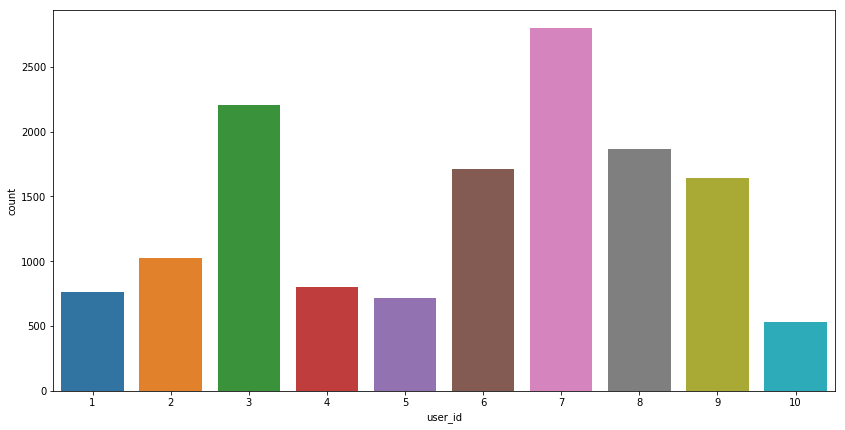

In [7]:
plt.figure(figsize=(14, 7))
sns.countplot(train_df['user_id']);

Посмотрим на распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов.

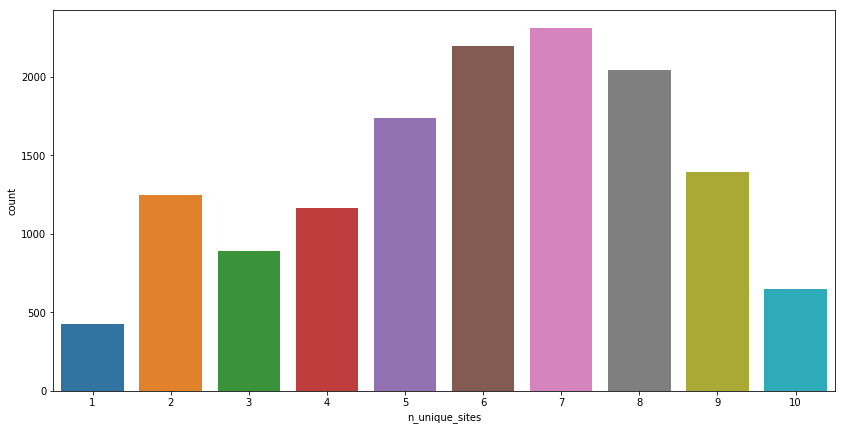

In [8]:
plt.figure(figsize=(14, 7))

num_unique_sites = pd.Series([np.unique(train_df.values[i, :-1]).shape[0] 
                    for i in range(train_df.shape[0])], name='n_unique_sites')
sns.countplot(num_unique_sites);

Кажется, что распределение у нас не нормальное из-за тяжелых хвостов. Если проверить это более формально с помощью критерия Шапиро-Уилка и QQ-графика, то увидиим что нулеввая гипотеза о нормальности распределения отвергается.

/usr/lib/python3.7/site-packages/scipy/stats/morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


p_value = 0.0


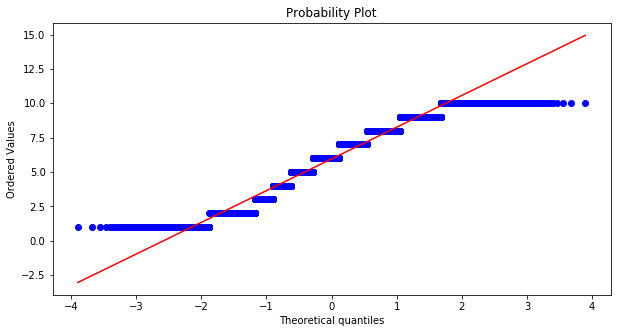

In [9]:
plt.figure(figsize=(10, 5))

print('p_value =', shapiro(num_unique_sites)[1])

probplot(num_unique_sites, plot=plt);

Теперь проверим гипотезу о том, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов. Делать это будем с помощью биномиального критерия для доли.
За нулевую гипотезу возьмем то что доля случаев, когда пользователь повторно посетил какой-то сайт (то есть число уникальных сайтов в сессии < 10) равна 95%, против альтернативной гипотезы $-$ доля больше 95%.

In [10]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')

pi_val = stats.binom_test(has_two_similar.sum(), has_two_similar.shape[0], 0.95, alternative='greater')
pi_val

0.02207653769072678

Достигаемый уровень значимости меньше 0.05, следовательно нулевая гипотеща отвергается в пользу альтернативы.

Построим распределение частоты посещения сайтов (сколько раз тот или иной сайт попадается в выборке) для сайтов, которые были посещены как минимум 1000 раз.

In [11]:
with open('capstone_user_identification/site_freq_10users.pkl', 'rb') as f:
    site_freqs = dict(pickle.load(f).values())

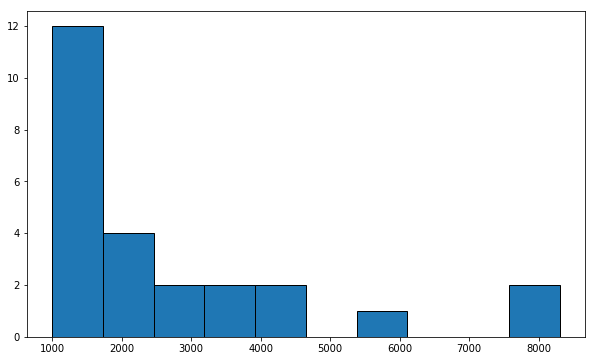

In [12]:
plt.figure(figsize=(10, 6))
freqs1000 = [site_freqs[site_id] for site_id in site_freqs if site_freqs[site_id] >= 1000]
plt.hist(freqs1000, edgecolor='black');

## Визуальный анализ данных и построение признаков

Создадим следующие признаки, а также визуально проанализируем их:

- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Поскольку для 150 проблематично делать визуальный анализ, то сделаем его для выборки из 10 пользователей. Также дадим каждому пользователю имя

In [13]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    assert session_length >= window_size
    
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)
    
    data = []

    users_list = glob(os.path.join(path_to_csv_files, '*.csv'))
    for user_id, csv_file in tqdm_notebook(enumerate(sorted(users_list), start=1)):
        df = pd.read_csv(csv_file, parse_dates=['timestamp'])
        sites = df['site'].values
        timestamps = df['timestamp']
        for i in range(0, len(sites), window_size):
            chunk_sites = sites[i: i + session_length]
            chunk_times = list(timestamps[i: i + session_length + 1])
            site_ids = [site_freq[chunk_sites[i]][0] if i < chunk_sites.shape[0] else 0 for i in range(session_length)]
            time_diffs = [(chunk_times[i + 1] - chunk_times[i]).seconds if i < chunk_sites.shape[0] - 1 
                          else 0 for i in range(session_length - 1)]
            if len(chunk_times) > len(chunk_sites): #учитываем время проведенное на последнем сайте
                time_diffs.append((chunk_times[-1] - chunk_times[-2]).seconds)
            else:
                time_diffs.append(0)
                
            session_timespan = np.sum(time_diffs[:-1])
            unique_sites = np.unique(chunk_sites).shape[0]
            start_hour = chunk_times[0].hour
            day_of_week = chunk_times[0].weekday()
            
            session = site_ids + time_diffs + [session_timespan, unique_sites, start_hour, day_of_week, user_id]
            
            data.append(session)
            
    return pd.DataFrame(data, columns=feature_names)

In [17]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

In [16]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                                               os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 
                                               feature_names, session_length=10)


CPU times: user 5.03 s, sys: 87.1 ms, total: 5.12 s
Wall time: 5.11 s


In [55]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

In [58]:
id_name_dict = {7: 'Mary-Kate', 3: 'Ashley', 8: 'Lindsey', 6: 'Naomi', 9: 'Avril',
               2: 'Bob', 4: 'Bill', 1: 'John', 5: 'Dick', 10: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

Построим гистограммы распределения длины сессии в секундах (session_timespan), распределения числа уникальных сайтов в сессии (#unique_sites), распределения часа начала сессии (start_hour) и распределения дня недели, в который началась сессия (day_of_week):

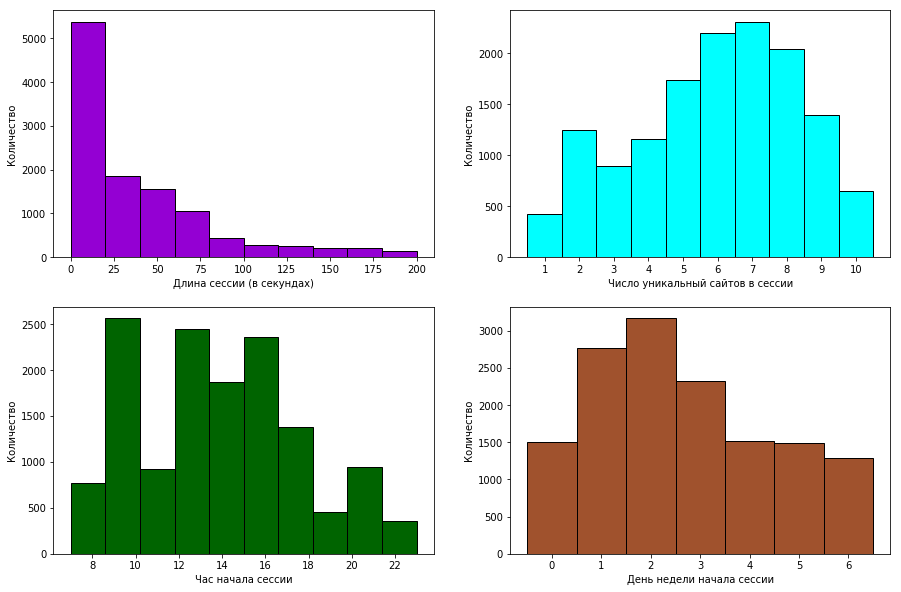

In [53]:
fig = plt.figure(figsize=(15, 10))

fig.add_subplot(2, 2, 1)
plt.hist(train_data_10users.query('session_timespan <= 200')['session_timespan'], color='darkviolet', 
         edgecolor='black')
plt.xlabel('Длина сессии (в секундах)')
plt.ylabel('Количество');

fig.add_subplot(2, 2, 2)
plt.hist(train_data_10users['#unique_sites'], color='aqua', edgecolor='black', align='left', bins=range(1, 12))
plt.xticks(range(1, 11))
plt.xlabel('Число уникальный сайтов в сессии')
plt.ylabel('Количество')

fig.add_subplot(2, 2, 3)
plt.hist(train_data_10users['start_hour'], color='darkgreen', edgecolor='black')
plt.xlabel('Час начала сессии')
plt.ylabel('Количество');


fig.add_subplot(2, 2, 4)
plt.hist(train_data_10users['day_of_week'], color='sienna', edgecolor='black', align='left', bins=range(8))
plt.xlabel('День недели начала сессии')
plt.ylabel('Количество');

Построим гистограммы распределения числа уникальных сайтов в сессии (#unique_sites) для каждого из 10 пользователей по отдельности.

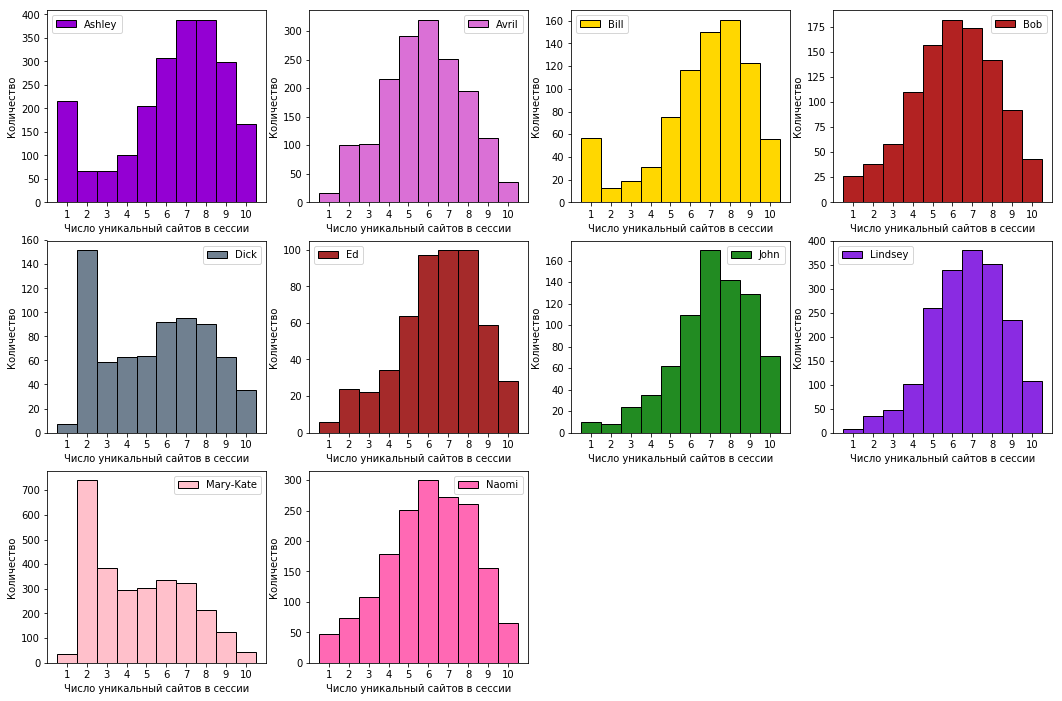

In [64]:
fig = plt.figure(figsize=(18, 12))
for idx, (user, sub_df) in enumerate(train_data_10users.groupby('target'), start=1): 
    fig.add_subplot(3, 4, idx)
    plt.hist(sub_df['#unique_sites'], edgecolor='black', label=user, color=color_dic[user], align='left', 
             bins=range(1, 12))
    plt.xticks(range(1, 11))
    plt.xlabel('Число уникальный сайтов в сессии')
    plt.ylabel('Количество')
    plt.legend()

Построим гистограммы распределения часа начала сессии (start_hour) для каждого из 10 пользователей по отдельности.

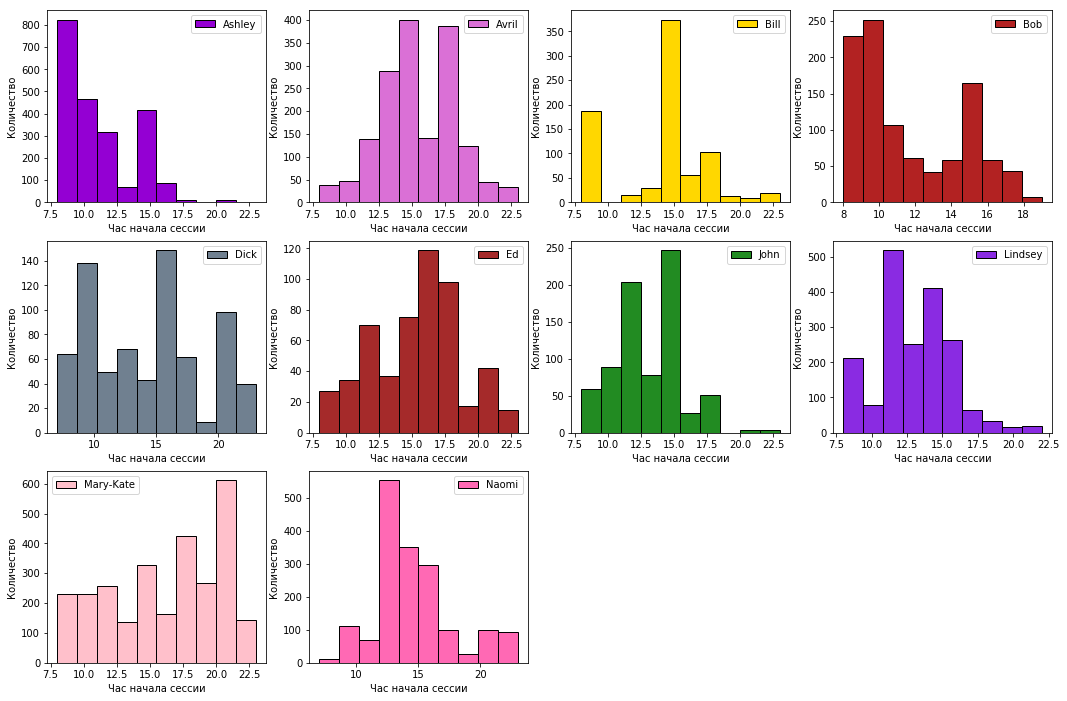

In [67]:
fig = plt.figure(figsize=(18, 12))

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target'), start=1): 
    fig.add_subplot(3, 4, idx)
    plt.hist(sub_df['start_hour'], color=color_dic[user], edgecolor='black', label=user)
    plt.xlabel('Час начала сессии')
    plt.ylabel('Количество')
    plt.legend()

Построим гистограммы распределения дня недели, в который началась сессия (day_of_week) для каждого из 10 пользователей по отдельности.

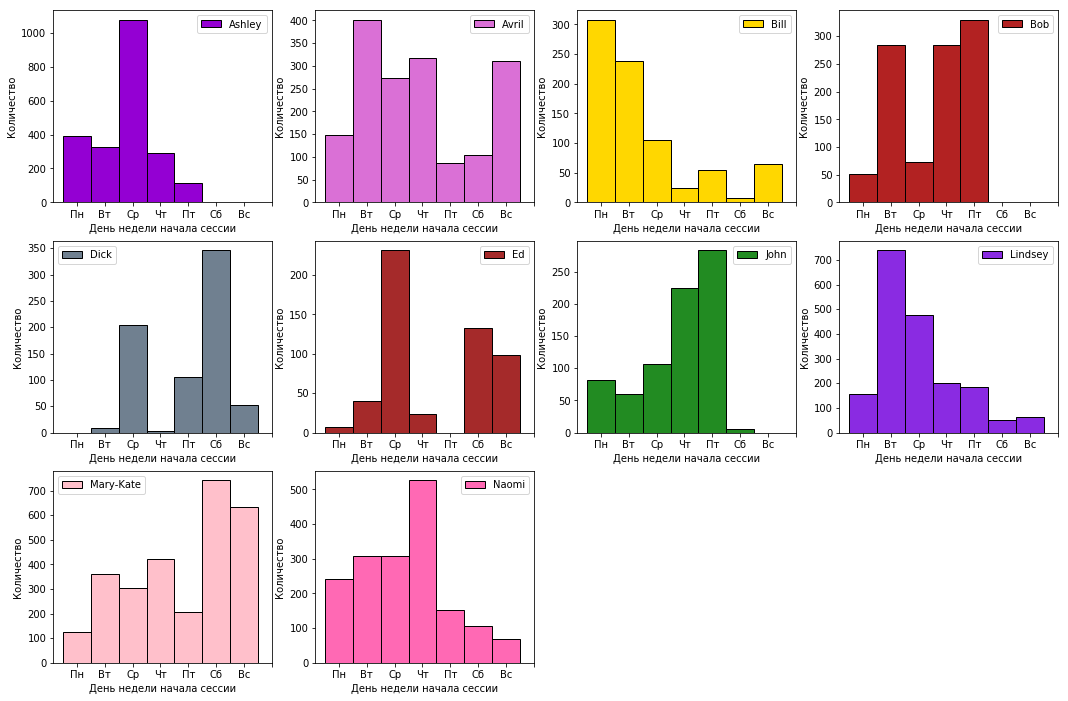

In [68]:
fig = plt.figure(figsize=(18, 12))

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target'), start=1): 
    fig.add_subplot(3, 4, idx)
    plt.hist(sub_df['day_of_week'], edgecolor='black', color=color_dic[user], label=user, bins=range(8), align='left')
    plt.xticks(range(8), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    plt.xlabel('День недели начала сессии')
    plt.ylabel('Количество')
    plt.legend()

По построенным графикам можно сделать следующие выводы:

**Ashley:** чаще всего посещает 7-8 сайтов за сессию в промежутке с 7 до 10 утра, пик активности приходится на среду  

**Avril:** обычно посещает 6 сайтов за сессию; наибольшая активность приходится на 15 и 17:30 часов во вторник и воскресенье. 

**Bill:** обычно посещает 8 сайтов за сессию; пик приходится на 15 часов и на начало рабочей недели (понедельник и вторник)

**Bob:** стандартная сессия составляет 6-7 сайтов, которая обычно начинается утром (с 8 до 10 утра); наибольший пик наблюдается в субботу, а также чуть меньшая активность во вторник и четверг

**Dick:** число уникальный сайтов в сессии обычно мало (2 сайта), проявляет наибольшую активность утром, после обеда и вечером; пик приходтся на субботу

**Ed:** сессися состоит обычно из 6-8 сайтов, проявляет активность после обеда (15 - 17,5 часов), пик приходится на среду

**John:** стандартная сессия $-$ 7 сайтов; пик приходится на четверг и пятницу; обычно сессии начинаются в обед (12 часов) и после обеда (15 часов)

**Lindsey:** чаще всего посещает 7 сайтов за сессию; сессиня начинается обычно в обед и во вторник

**Mary-Kate:** чаще всего сессия состоит из 2 сайтов; пик приходится на выходные (суббота, воскресенье) в вечернее время (17 и 20-22 часов)

**Naomi:** число уникальный сайтов обычно составляет 5-8; начало сессии обычно приходится на 12 часов; пик наблюдается в четверг

По построенным признакам можно сделать следующие предположения:
* число уникальных сайтов, скорее всего, не влияет на идентификацию пользователя
* день недели и час начала сессии кажутся значимыми признаками

Построим еще некоторые новые признаки, такие как время суток (day_period), индикаторы посещения топ сайтов, а также время пребывания на популярных сайтах в течение сессии и посмотрим на целесообразность данных признаков в этой задаче.

In [69]:
def create_time_period_feature(df):
    
    def get_time_period(hour):
        if 0 <= hour < 6:
            return 0
        elif 6 <= hour < 12:
            return 1
        elif 12 <= hour < 18:
            return 2
        elif 18 <= hour < 24:
            return 3
    
    time_period = df['start_hour'].apply(get_time_period)
    time_period.name = 'time_period'
    return time_period

def create_top_indicator_features(df, top_site_ids):
        
    result_df = pd.DataFrame()
    for top_site_id in top_site_ids:
        feature_name = f'ind_site_id_{top_site_id}'
        result_df[feature_name] = df.apply(lambda row: 1 if top_site_id in list(row) else 0, axis=1)
    
    return result_df
    
def create_top_timespan_features(df, top_site_ids, session_length):
    
    def get_top_site_timespan(row, top_site_id, session_length):
        session_sites = row.values[:session_length]
        session_time_diffs = row.values[session_length:]
        return np.sum(session_time_diffs[np.argwhere(session_sites == top_site_id)])
    
    result_df = pd.DataFrame()
    for top_site_id in top_site_ids:
        feature_name = f'timespan_site_id_{top_site_id}'
        result_df[feature_name] = df.apply(lambda row: get_top_site_timespan(row, top_site_id, session_length), axis=1)
    
    return result_df

def feature_engineering(path_to_csv_files, site_freq_path, session_length=10, window_size=10,
                        number_top_sites=30, *, df=None, option=0):
    
    """
        option 0 -- default train set
        option 1 -- default train set + new_features
        option 2 -- new_features 
    """
        
    sites_features = [f'site{i}' for i in range(1, session_length + 1)]
    time_diffs_features = [f'time_diff{i}' for i in range(1, session_length + 1)]   
    sites_timediffs_features = sites_features + time_diffs_features

    main_features = (sites_features + time_diffs_features + 
                     ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target'])
    
    if option == 0: 
        return prepare_train_set_with_fe(path_to_csv_files, site_freq_path, main_features, 
                                         session_length, window_size)
    elif option == 1:
        if df is None:
            df = prepare_train_set_with_fe(path_to_csv_files, site_freq_path, main_features, 
                                         session_length, window_size)
        
        with open(site_freq_path, 'rb') as f:
            site_freq = pickle.load(f)
        
        top_site_ids = [site_id for site_id, _freq in sorted(site_freq.values(), key=lambda x: x[1], 
                                                         reverse=True)[:number_top_sites]]
                  
        return pd.concat([df, create_top_indicator_features(df[sites_features], top_site_ids), 
                          create_top_timespan_features(df[sites_timediffs_features], top_site_ids, session_length), 
                          create_time_period_feature(df)], axis=1)
    
    elif option == 2:
        if df is None:
            df = prepare_train_set_with_fe(path_to_csv_files, site_freq_path, main_features, 
                                         session_length, window_size)
        
        with open(site_freq_path, 'rb') as f:
            site_freq = pickle.load(f)
        
        top_site_ids = [site_id for site_id, _freq in sorted(site_freq.values(), key=lambda x: x[1], 
                                                         reverse=True)[:number_top_sites]]
                  
        return pd.concat([create_top_indicator_features(df[sites_features], top_site_ids), 
                          create_top_timespan_features(df[sites_timediffs_features], top_site_ids, session_length), 
                          create_time_period_feature(df)], axis=1)   

In [70]:
%%time
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), 
                                           os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 
                                           session_length=10, window_size=10, number_top_sites=30, 
                                           df=train_data_10users, option=2)

CPU times: user 19.7 s, sys: 120 ms, total: 19.8 s
Wall time: 21.3 s


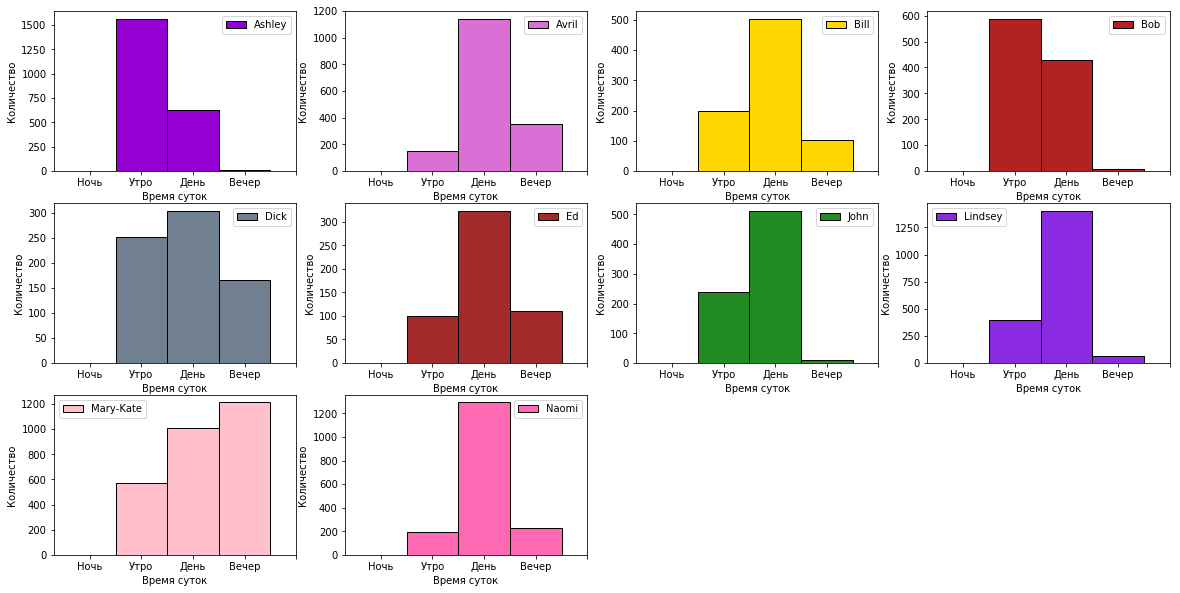

In [71]:
fig = plt.figure(figsize=(20, 10))
for idx, (user, subdf) in enumerate(new_features_10users.groupby(train_data_10users['target']), start=1):
    fig.add_subplot(3, 4, idx)
    plt.hist(subdf['time_period'], edgecolor='black', align='left', bins=range(5), color=color_dic[user], label=user)
    plt.xticks(range(5), ['Ночь', 'Утро', 'День', 'Вечер'])
    plt.xlabel('Время суток')
    plt.ylabel('Количество')
    plt.legend()

Видно, что у некоторых пользователей активность зависит от времени суток.

Посмотрим теперь на общее число посещений сайта из топ-30 за все сессии

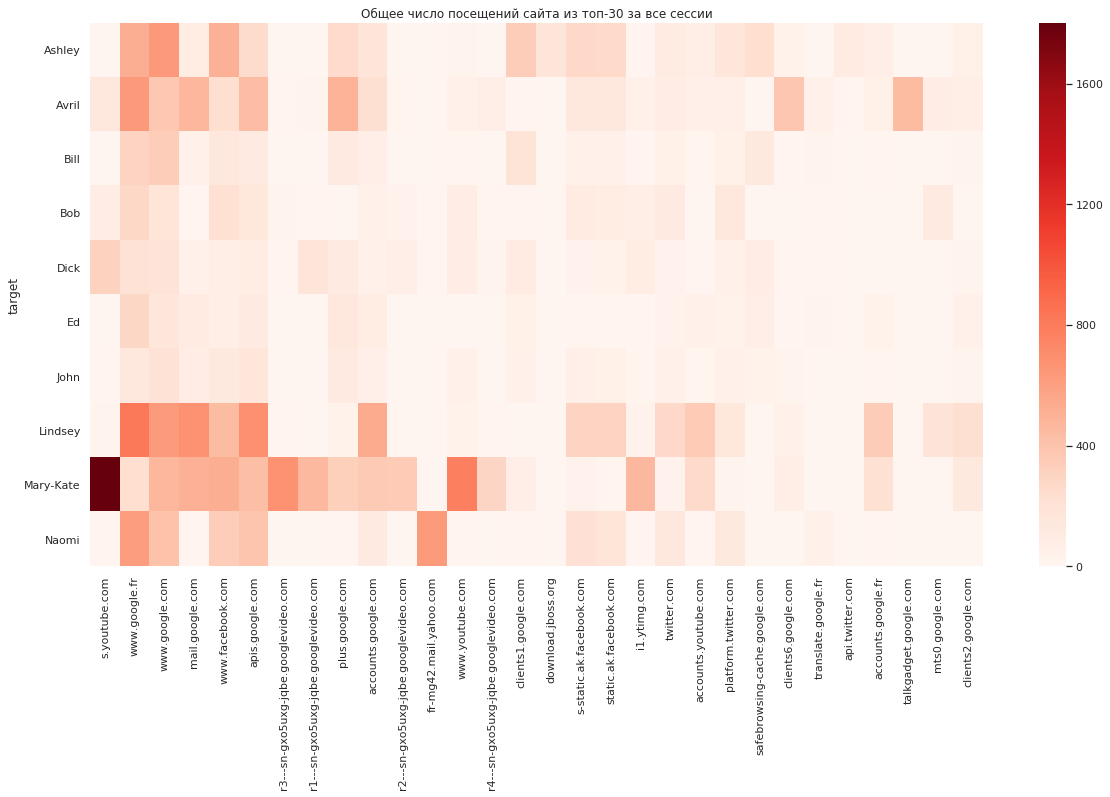

In [124]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    site_freq_10users = pickle.load(f)
    
top_30 = sorted(site_freq_10users.items(), key=lambda x: x[1][1], reverse=True)[:30]
top30_sites = [site for site, (_id, _freq) in top_30]

columns_indicators = [f'ind_site_id_{i}' for i in range(1, 31)]

plt.figure(figsize=(20, 10))
plt.title('Общее число посещений сайта из топ-30 за все сессии')
ax = sns.heatmap(new_features_10users.groupby(train_data_10users['target']).apply(np.sum)[columns_indicators], cmap='Reds');

ax.set_xticklabels(top30_sites);

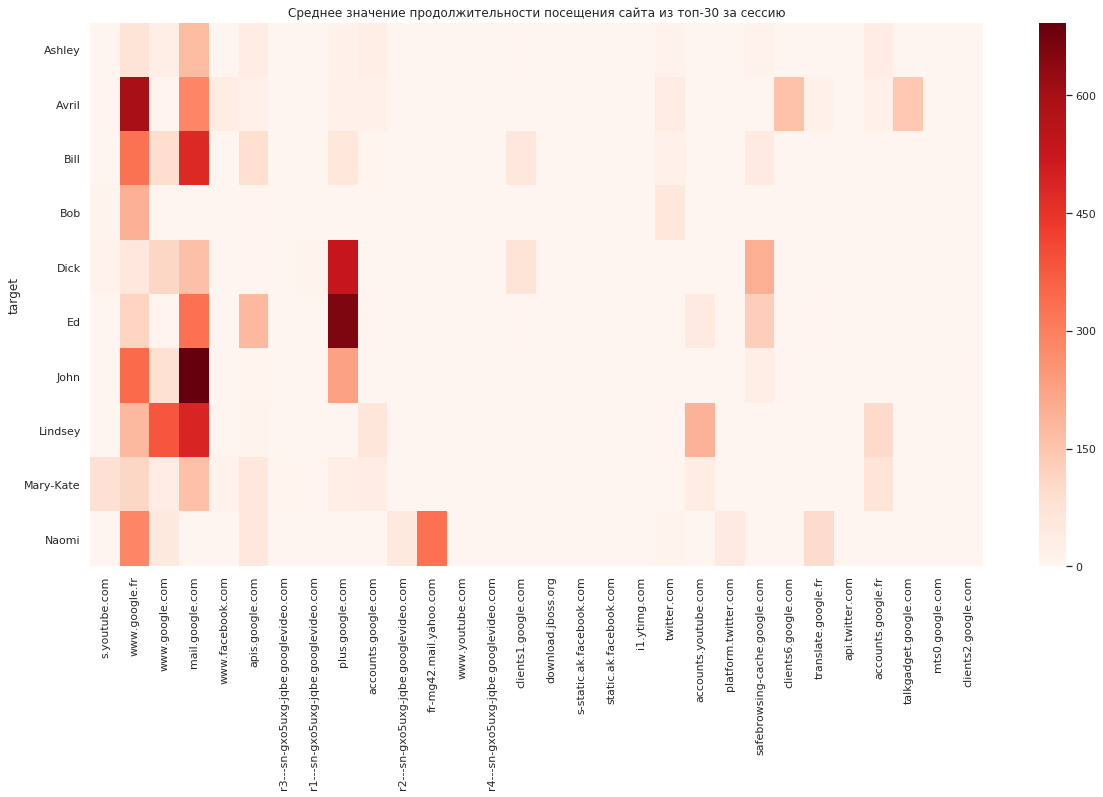

In [123]:
columns_timespans = [f'timespan_site_id_{i}' for i in range(1, 31)]

plt.figure(figsize=(20, 10))
plt.title(u'Среднее значение продолжительности посещения сайта из топ-30 за сессию')
ax = sns.heatmap(new_features_10users.groupby(train_data_10users['target']).apply(np.mean)[columns_timespans],
                 cmap='Reds')

ax.set_xticklabels(top30_sites);

На тепловых картах видны различия между пользователями, поэтому данные признаки, скорее всего, могут быть важными.

## Выбор модели классификации

Сравним 4 алгоритма классификации с параметрами по умолчанию, а именно k-ближайших соседей, случайный лес, логистическую регрессия и линейный метод опорных векторов и выберем лучший из них для дальнейшего подбора параметров.

Загрузим сериализованные объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.

In [96]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.

In [100]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.

In [101]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

Вспомогательная функция для отрисовки кривых валидации после запуска `GridSearchCV` (или `RandomizedCV`).

In [102]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

Обучим `KNeighborsClassifier` со 100 ближайшими соседями и посмотрим на долю правильных ответов на 3-кратной кросс-валидации по выборке `(X_train, y_train)` и отдельно на долю правильных ответов на выборке `(X_valid, y_valid)`.

In [112]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

knn_scores = cross_val_score(knn, X_train, y_train, cv=skf, n_jobs=-1, scoring='accuracy')

knn_mean = knn_scores.mean()
print('CV mean:', knn_mean)

knn.fit(X_train, y_train)

knn_valid_score = accuracy_score(y_valid, knn.predict(X_valid))
print('Valid score:', knn_valid_score)

CV mean: 0.5647188870063362
Valid score: 0.584024650391088


Обучим случайный лес (`RandomForestClassifier`) из 100 деревьев. Посмотрим на out-of-bag (OOB) оценку и на долю правильных ответов на выборке `(X_valid, y_valid)`.

In [109]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1)

forest.fit(X_train, y_train)

oob_score = forest.oob_score_
print('OOB-score:', oob_score)

forest_valid_score = accuracy_score(y_valid, forest.predict(X_valid))
print('Valid score:', forest_valid_score)

OOB-score: 0.7212964844543792
Valid score: 0.7293197440151695


Обучим логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию. Посмотрим на долю правильных ответов на кросс-валидации и на выборке `(X_valid, y_valid)`.

In [110]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

logit = LogisticRegression(random_state=17, n_jobs=-1)

logit_scores = cross_val_score(logit, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)

logit_mean = logit_scores.mean()
print('CV score:', logit_scores.mean())

logit.fit(X_train, y_train)

logit_valid_score = accuracy_score(y_valid, logit.predict(X_valid))
print('Valid score', logit_valid_score)

CV score: 0.7610267543665875
Valid score 0.7817018250770325


Обучим линейный SVM (`LinearSVC`) с параметром `C`=1. Посмотрим на долю правильных ответов на кросс-валидации и на выборке `(X_valid, y_valid)`.

In [111]:
from sklearn.svm import LinearSVC

svm = LinearSVC(C=1, random_state=17)

svm_scores = cross_val_score(svm, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1)

print('CV score:', svm_scores.mean())

svm.fit(X_train, y_train)

print('Valid score', accuracy_score(y_valid, svm.predict(X_valid)))

CV score: 0.7526960152920014
Valid score 0.7769613652524295


Лучшее качество показали логистическая регрессия и линейный SVM. С ними и будем работать дальше.

### Подбор параметров моделей

Подберем оптимальный гипепараметр `C` для логистической регрессии в диапазоне `np.linspace`(0.1, 7, 20). Нарисуем кривую валидации и определим максимальное значение доли правильных ответов на кросс-валидации.

In [154]:
logit_c_values = np.linspace(3, 7, 20)

logit_grid_searcher = LogisticRegressionCV(Cs=logit_c_values, cv=skf, multi_class='multinomial', n_jobs=-1, 
                                            random_state=17)
logit_grid_searcher.fit(X_train, y_train)

logit_mean_cv_scores  = list(logit_grid_searcher.scores_.values())[0].mean(axis=0)

best_logit_mean_cv_scores = max(logit_mean_cv_scores)
best_C = logit_grid_searcher2.Cs_[np.argmax(logit_mean_cv_scores)]

print('Best score:', best_logit_mean_cv_scores)
print('Best C =', best_C)

Best score: 0.7595049940738708
Best C = 3.0


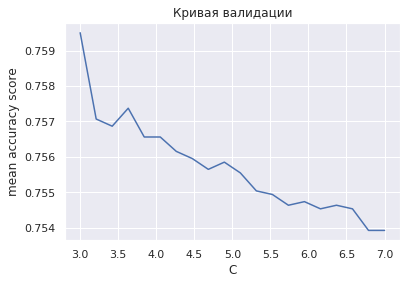

In [155]:
plt.plot(logit_c_values, logit_mean_cv_scores)
plt.xlabel('C')
plt.ylabel('mean accuracy score')
plt.title('Кривая валидации');

Выведем точность с подобранным параметром на валидационной выборке

In [156]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher.predict(X_valid))
logit_cv_acc

0.7795686181559611

Качество немного улучшилось

С помощью `GridSearchCV` подберем параметр C для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4 b нарисуем кривую валидации.

In [129]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1, scoring='accuracy', n_jobs=-1, cv=skf)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 3.4 s, sys: 118 ms, total: 3.52 s
Wall time: 38.9 s


In [130]:
print('Best score:', svm_grid_searcher1.best_score_)
print('Best C:', svm_grid_searcher1.best_params_['C'])

Best score: 0.6842105263157895
Best C: 6666.666700000001


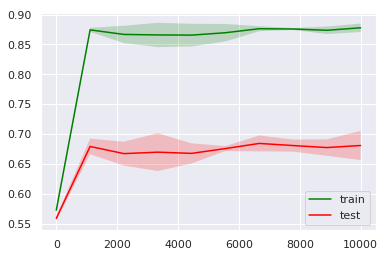

In [131]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

Качество стало только хуже. Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. То есть мы выбрали неправильный диапазон перебора параметров. Причина заключается в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. 

Поэтому с помощью `GridSearchCV` подберем параметр `C` для SVM, перебирая 30 значений в диапазоне (1e-3, 1 и нарисуем кривые валидации.

In [132]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2, scoring='accuracy', n_jobs=-1, cv=skf)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 1.06 s, sys: 117 ms, total: 1.17 s
Wall time: 55.6 s


In [133]:
print('Best score:', svm_grid_searcher2.best_score_)
print('Best C:', svm_grid_searcher2.best_params_['C'])

Best score: 0.764681975208291
Best C: 0.10434482758620689


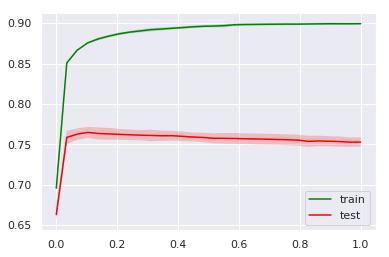

In [134]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Посмотрим на долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [135]:
svm_valid_acc = accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid))
svm_valid_acc

0.7807537331121118

### Выбор параметров – длины сессии и ширины окна

Поскольку линейный SVM показал лучшее качество, то возьмем его в качестве бейзлайна и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров `session_length` и `window_size`). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.

In [137]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    with open(path_to_X_pickle, 'rb') as X_file, open(path_to_y_pickle, 'rb') as y_file:
        X_sparse = pickle.load(X_file)
        y = pickle.load(y_file)
    
    X_train, X_valid, y_train, y_valid =  train_test_split(X_sparse, y, test_size=test_size, 
                                                           random_state=random_state, stratify=y)
    
    mean_cv_score = cross_val_score(estimator, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1).mean()
    estimator.fit(X_train, y_train)
    acc_valid_score = accuracy_score(y_valid, estimator.predict(X_valid))
    
    return mean_cv_score, acc_valid_score

In [146]:
%%time
estimator = svm_grid_searcher2.best_estimator_
scores = []
for window_size, session_length in product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, f'X_sparse_10users_s{session_length}_w{window_size}.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, f'y_10users_s{session_length}_w{window_size}.pkl')
        cv_score, valid_score = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3)
        scores.append((session_length, window_size, cv_score, valid_score))
        print(f'session_length: {session_length}, window_size: {window_size}, cv_score: {cv_score}, valid_score: {valid_score}')

session_length: 15, window_size: 10, cv_score: 0.8238214955278105, valid_score: 0.8404835269021095
session_length: 10, window_size: 10, cv_score: 0.7646853244550981, valid_score: 0.7807537331121118
session_length: 15, window_size: 7, cv_score: 0.8479403769844098, valid_score: 0.8543222166915547
session_length: 10, window_size: 7, cv_score: 0.7970161463734652, valid_score: 0.8073668491786958
session_length: 7, window_size: 7, cv_score: 0.7529891114830342, valid_score: 0.7617388418782147
session_length: 15, window_size: 5, cv_score: 0.868001372554347, valid_score: 0.8752963489805595
session_length: 10, window_size: 5, cv_score: 0.8159247205318039, valid_score: 0.8245614035087719
session_length: 7, window_size: 5, cv_score: 0.774058674563226, valid_score: 0.7853247984826932
session_length: 5, window_size: 5, cv_score: 0.7252830650398828, valid_score: 0.7362494073020389
CPU times: user 11.1 s, sys: 614 ms, total: 11.7 s
Wall time: 26 s


In [149]:
pd.DataFrame(scores, columns=['session_length', 'window_size', 'cv_score', 'valid_score'])\
             .sort_values('valid_score', ascending=False)

,session_length,window_size,cv_score,valid_score
5,15,5,0.868001,0.875296
2,15,7,0.847940,0.854322
0,15,10,0.823821,0.840484
6,10,5,0.815925,0.824561
3,10,7,0.797016,0.807367
7,7,5,0.774059,0.785325
1,10,10,0.764685,0.780754
4,7,7,0.752989,0.761739
8,5,5,0.725283,0.736249


Лучшее качество на кросс-валидации и на отложенной выборке показали параметры `session_length=15` и `window_size=5`. Будем дальше работать с этими параметрами.

In [189]:
path_to_X_pkl = os.path.join(PATH_TO_DATA, f'X_sparse_10users_s15_w5.pkl')
path_to_y_pkl = os.path.join(PATH_TO_DATA, f'y_10users_s15_w5.pkl')

with open(path_to_X_pkl, 'rb') as X_file, open(path_to_y_pkl, 'rb') as y_file:
        X_sparse = pickle.load(X_file)
        y = pickle.load(y_file)

In [197]:
feature_names_s15_w5 = ['site' + str(i) for i in range(1,16)] + \
                ['time_diff' + str(j) for j in range(1,16)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_10users_s15_w5 = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                                               os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 
                                               feature_names_s15_w5, session_length=15, window_size=5)

In [199]:
%%time
new_features_10users_s15_w5 = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), 
                                           os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 
                                           session_length=15, window_size=5, number_top_sites=30, 
                                           df=train_data_10users_s15_w5, option=2)

CPU times: user 40.4 s, sys: 281 ms, total: 40.7 s
Wall time: 41.4 s


In [225]:
def get_valid_score(estimator, X, y, test_size=0.3, seed=17):
    X_train, X_valid, y_train, y_valid =  train_test_split(X, y, test_size=test_size, 
                                                       random_state=seed, stratify=y)
    estimator.fit(X_train, y_train)
    acc_valid_score = accuracy_score(y_valid, estimator.predict(X_valid))
    return acc_valid_score

Посмотрим как работают наши признаки, сгенерированные на предыдущих шагах. Попробуем добавить к модели признак "время суток".

In [211]:
X_sparse_tp = hstack([X_sparse, new_features_10users_s15_w5['time_period'].values.reshape(-1, 1)])

In [224]:
get_valid_score(estimator, X_sparse_tp, y)

0.8837126600284495

Качество на валидации улучшилось.

Добавим теперь признак час начала сессии `start_hour`

In [226]:
X_sparse_tp_sh = hstack([X_sparse_tp, train_data_10users_s15_w5['start_hour'].values.reshape(-1, 1)])
get_valid_score(estimator, X_sparse_tp_sh, y)

0.8856092935040304

Качество улучшилось, но не значительно.

Добавим число уникальных сайтов `#unique_sites`

In [227]:
X_sparse_tp_sh_nu = hstack([X_sparse_tp_sh, train_data_10users_s15_w5['#unique_sites'].values.reshape(-1, 1)])
get_valid_score(estimator, X_sparse_tp_sh_nu, y)

0.8869132290184921

Снова получили незначительный прирост к качеству. Посмотри на день недели `day_of_week`, предварительно преобразовав данный признак с помощью `One-Hot-Encoding` техники, поскольку он категориальный.

In [230]:
X_sparse_tp_sh_nu_dow = hstack([X_sparse_tp_sh_nu, 
                                pd.get_dummies(train_data_10users_s15_w5['day_of_week']).values])
get_valid_score(estimator, X_sparse_tp_sh_nu_dow, y)

0.905049786628734

Как и предполагалось, данный признак вносит весомый вклад.

Добавим прихнак длина сессии в секундах `session_timespan`.

In [232]:
X_sparse_tp_sh_nu_dow_stime = hstack([X_sparse_tp_sh_nu_dow, 
                                      train_data_10users_s15_w5['session_timespan'].values.reshape(-1, 1)])
get_valid_score(estimator, X_sparse_tp_sh_nu_dow_stime, y)

0.8283546704599336

Качество сильно упало. Скорее всего, это связано с тем, что мы не отмасштабировали признак. Попробуем сделать это.

In [235]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

sess_time_scaled = scaler.fit_transform(train_data_10users_s15_w5['session_timespan'].values.reshape(-1, 1))
X_sparse_tp_sh_nu_dow_stime = hstack([X_sparse_tp_sh_nu_dow, sess_time_scaled])
get_valid_score(estimator, X_sparse_tp_sh_nu_dow_stime, y)

0.9048127074442864

Как и предполагалось, качество выросло. Однако данный признак оказался избыточным и его нет смысла добавлять в модель.

Добавим индикаторы популярных сайтов.

In [237]:
X_sparse_tp_sh_nu_dow_sites30ind = hstack([X_sparse_tp_sh_nu_dow, 
                                           new_features_10users_s15_w5[columns_indicators].values])
get_valid_score(estimator, X_sparse_tp_sh_nu_dow_sites30ind, y)

0.9089615931721194

Индикаторы популярных сайтов еще немного улучшили модель. 

Посмотрим как работают признаки "время проведенное на популярных сайтах", предварительно их отмасштабировав.

In [239]:
X_sparse_tp_sh_nu_dow_sites30ind_timestop30 = hstack([X_sparse_tp_sh_nu_dow_sites30ind, 
    scaler.fit_transform(new_features_10users_s15_w5[columns_timespans])])
get_valid_score(estimator, X_sparse_tp_sh_nu_dow_sites30ind_timestop30, y)

0.9110953058321479

Как видно, наши гипотезы подтвердились. Оба добавленных нами признака улучшили качество модели.

В итоге, с помощью подбора гиперпараметров и конструирования признаков мы смогли поднять качество нашей модели с 0.78 до 0.91. Это очень хороший результат.

Многоклассовая классификация для 150 пользователей работает плохо и долго, поэтому мы не будем здесь приводить полученные результаты, стоит лишь заметить, что в среднем качество < 0.5

Однако конкретного пользователя можно идентифицировать достаточно хорошо. Этим мы и займемся.

Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.

In [158]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [159]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

Обучим `LogisticRegressionCV` для одного значения параметра `C`. Теперь будем решать 150 задач "Один-против-Всех".

In [160]:
%%time

logit_cv_150users = LogisticRegressionCV(Cs=[best_C], multi_class='ovr', cv=skf, 
                                         scoring='accuracy', n_jobs=-1, random_state=17)
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 8min 47s, sys: 10min, total: 18min 48s
Wall time: 17min 59s


Посмотрим на средние доли правильных ответов на кросс-валидации в задаче идентификации для некоторых пользователей (для остальных все аналогично)

In [162]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] = logit_cv_150users.scores_[user_id].mean()

* User 1, CV score: 0.9958396485310578
* User 2, CV score: 0.996236159606072
* User 3, CV score: 0.9951414156621485
* User 4, CV score: 0.9917629636028263
* User 5, CV score: 0.990032646749408
* User 6, CV score: 0.9945992933895361

Скорее всего такая точность связана с дисбалансом классов, поскольку мы решаем задачу бинарной классификации "один против всех". Из-за сильного дисбаланса класса высокую точность можно получить с помощью константного прогноза, поэтому найдем общее число и долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного.

In [163]:
class_distr = np.bincount(y_train_150.astype('int'))

acc_diff_vs_constant = {}
for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id] - (1 - class_distr[user_id] / len(y_train_150))

In [165]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
print('Общее число пользователей:', num_better_than_default)
print('Доля пользователей:', round((num_better_than_default)  / len(acc_diff_vs_constant), 3))

Общее число пользователей: 124
Доля пользователей: 0.827


Дальше построим кривые обучения для конкретного пользователя, допустим, для 128-го.

In [166]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

In [179]:
y_binary_128 = (y_150users == 118).astype(int)

In [183]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_binary_128, cv=skf, shuffle=True,
                                              train_sizes=train_sizes, n_jobs=-1, random_state=17)

CPU times: user 1.71 s, sys: 110 ms, total: 1.82 s
Wall time: 18.1 s


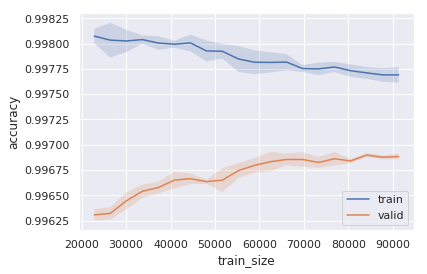

In [184]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

Поскольку между валидационной и тренировочной кривой большой разрыв и мы имеем высокое качество классификатора, то увеличение тренировочной выборки, возможно, увеличит точность на валидационной.

## Выводы

В ходе выполнения настоящего проекта была разработана модель идентификации пользователя в сети интернет по его поведению. Как уже отмечалось, это сложная и интересная задача на стыке анализа данных и поведенческой психологии. Выявляя особенности поведения конкретного пользователя - как, в каком порядке, с какими временными интервалам, когда и т.д. - мы можем отличить одного пользователя от другого. 

В данном проекте использовались и сравнивались несколько алгоритмов классификации и их реализации, а именно:

* k-ближайших соседей
* случайный лес
* логистическая регрессия
* метод опорных векторов (SVM) с линейным ядром 

Лучшее качество показал SVM.

В данной задаче идентификации, как и в большинстве задач Data Science, огромную роль играет предобработка данных и построение признаков. В данной модели была использована техника `bag-of-words`. Однако корректное добавление дополнительных признаков значительно улучшает качество модели (с **0.78** до **0.91**). В данном проекте дополнительные признаки конструировались из временных меток, соответствующих данным. Хотелось бы отметить, что то, как мы учитываем дополнительную информацию в признаках, сильно влияет на результат, а конкретнее - очень важно для линейных моделей масштабировать признаки, а также делать `OHE` кодирование категориальных.

Задача идентификации пользователя в интернете, решаемае в настоящем проекте, может имет важное практическое значение.
Сейчас роль интернета в деловой жизни общества все более повышается. Множество услуг уходит в интернет, люди пользуются своими аккаунтами, через которые получают услуги. А качество услуги во многом зависит от безопасности, которую может обеспечить провайдер услуги, насколько эффективно он может противодействовать взлому аккаунтов своих пользователей. И вот мы уже пришли к задаче идентификации в интернете. Это может быть идентификация пользователей:

* почтовых аккаунтов
* аккаунтов при банковском онлайн-обслуживании
* пользователи соцсетей
* пользователи других онлайн-сервисов. 

Все это - задачи, аналогичные той, которая решалась в ходе данного Проекта. Для разных сервисов могут быть свои особенности при построении признаков или учете каких-то еще особенностей работы этих сервисов. В зависимости от ситуации, это может быть бинарная или многоклассовая классификация.